In [11]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

# define global variables
SPEED_OF_LIGHT = 3e8
ELEMENTARY_CHARGE = 1.602e-19
EARTH_RADIUS = 6.371 * (1e6)
RAD_PER_DEG = np.pi / 180.
KG_PER_GEVC2 = 1.78e-27
KGMS_PER_GEVC = 5.36e-19

KEY_LIST = ["t", "r", "theta", "phi", "pr", "ptheta", "pphi"]

# define the spherical components of Earth magnetic field
G10 = 2.91e-5  # value of B-field at center of Earth


In [12]:
def Br(r, theta, phi):
    return -2. * (EARTH_RADIUS / r)**3. * G10 * np.cos(theta)


def Btheta(r, theta, phi):
    return -(EARTH_RADIUS / r)**3. * G10 * np.sin(theta)


def Bphi(r, theta, phi):
    return 0.


In [70]:
# ODEs in spherical coordinates,
# based on lorentz force and the form of
# acceleration in spherical coordinates
def drdt(pr):
    return pr


def dthetadt(r, ptheta):
    return ptheta / r


def dphidt(r, theta, pphi):
    # dphi_dt = 0.0 if abs(theta) < 1e-12 else pphi / (r * np.sin(theta))
    return pphi / (r * np.sin(theta))


def dprdt(charge, r, theta, phi, pr, ptheta, pphi):
    lorentz_term = charge * (ptheta * Bphi(r, theta, phi) -
                             pphi * Btheta(r, theta, phi))
    auxiliary_terms = (ptheta**2. / r) + (pphi**2. / r)
    return lorentz_term + auxiliary_terms


def dpthetadt(charge, r, theta, phi, pr, ptheta, pphi):
    lorentz_term = -charge * (pr * Bphi(r, theta, phi) -
                              pphi * Br(r, theta, phi))
    auxiliary_terms = (pphi**2. / (r * np.tan(theta))) - ((pr * ptheta) / r)
    return lorentz_term + auxiliary_terms


def dpphidt(charge, r, theta, phi, pr, ptheta, pphi):
    lorentz_term = charge * (pr * Btheta(r, theta, phi) -
                             ptheta * Br(r, theta, phi))
    auxiliary_terms = ((pr * pphi) / r) + ((ptheta * pphi) /
                                           (r * np.tan(theta)))
    return lorentz_term - auxiliary_terms

In [162]:
# convert between coordinates defined in detector frame with geocentric coordinates
def detector_to_geocentric(lat, lng, detector_alt, zenith, azimuth,
                           particle_alt, momentum):

    # first convert angles (latitude, longitude, zenith, azimuth)
    # to radians
    lat *= RAD_PER_DEG
    lng *= RAD_PER_DEG
    zenith *= RAD_PER_DEG
    azimuth *= RAD_PER_DEG

    # now convert the coordinates / momentum
    # this can realistically be done in one step by utilizing matrix multiplication
    # with transformation matrices between cartesian, geodesic, and spherical

    # convert detector latitude, longitude, altitude into cartesian
    detector_x = (detector_alt + EARTH_RADIUS) * np.cos(lat) * np.cos(lng)
    detector_y = (detector_alt + EARTH_RADIUS) * np.cos(lat) * np.sin(lng)
    detector_z = (detector_alt + EARTH_RADIUS) * np.sin(lat)

    detector_geoc_coord = np.array([detector_x, detector_y, detector_z])

    # convert zenith, azimuth, and particle altitude to cartesian in detector frame
    particle_detector_x = (particle_alt +
                           EARTH_RADIUS) * np.sin(zenith) * np.cos(azimuth)
    particle_detector_y = (particle_alt +
                           EARTH_RADIUS) * np.sin(zenith) * np.sin(azimuth)
    particle_detector_z = (particle_alt + EARTH_RADIUS) * np.cos(zenith)

    particle_detector_coord = np.array(
        [particle_detector_x, particle_detector_y, particle_detector_z])

    # the transformation matrix between detector frame and geodesic coordinates
    row1 = np.array(
        [-np.sin(lng), -np.cos(lng) * np.sin(lat),
         np.cos(lat) * np.cos(lng)])
    row2 = np.array(
        [np.cos(lng), -np.sin(lat) * np.sin(lng),
         np.cos(lat) * np.sin(lng)])
    row3 = np.array([0., np.cos(lat), np.sin(lat)])

    transform_matrix = np.array([row1, row2, row3])
    
    print(transform_matrix)

    # now get the transformed coordinate vector in geocentric frame
    (particle_geoc_x,
     particle_geoc_y, particle_geoc_z) = detector_geoc_coord + np.dot(
         transform_matrix, particle_detector_coord)

    particle_r = np.sqrt(particle_geoc_x**2. + particle_geoc_y**2. +
                         particle_geoc_z**2.)
    particle_theta = np.arccos(particle_geoc_z / particle_r)
    particle_phi = np.arctan2(particle_geoc_y, particle_geoc_x)

    # now for momentum
    # convert the direction of the momentum of the particle (defined by zenith and azimuth angles)
    # with the magnitude of the momentum (obtained by energy / rigidity)
    particle_detector_px = momentum * np.sin(zenith) * np.cos(azimuth)
    particle_detector_py = momentum * np.sin(zenith) * np.sin(azimuth)
    particle_detector_pz = momentum * np.cos(zenith)

    particle_detector_momentum = np.array(
        [particle_detector_px, particle_detector_py, particle_detector_pz])
    
    print(particle_detector_momentum)

    # now transform the momentum vector into geocentric frame
    (particle_geoc_px, particle_geoc_py,
     particle_geoc_pz) = np.dot(transform_matrix, particle_detector_momentum)
    
    print(particle_geoc_px, particle_geoc_py,
     particle_geoc_pz)

    # here we should have conversion between cartesian and spherical again
    # but for momenta its more complicated
    # double check if this is actually correct (like the /r , /rsin(theta) parts)
    #  -> this is fixed, it should be removed to keep units consistent
    particle_pr = particle_geoc_px * np.sin(particle_theta) * np.cos(particle_phi) + \
            particle_geoc_py * np.sin(particle_theta) * np.sin(particle_phi) + \
            particle_geoc_pz * np.cos(particle_theta)
    
    particle_ptheta = (
        particle_geoc_px * np.cos(particle_theta) * np.cos(particle_phi) +
        particle_geoc_py * np.cos(particle_theta) * np.sin(particle_phi) -
        particle_geoc_pz * np.sin(particle_theta))
    particle_pphi = (-particle_geoc_px * np.sin(particle_phi) +
                     particle_geoc_py * np.cos(particle_phi))
    
    particle_sixvector = np.array([
        particle_r, particle_theta, particle_phi, particle_pr, particle_ptheta,
        particle_pphi
    ])

    return particle_sixvector

In [163]:
# perform the Runge kutta sequence
def perform_runge_kutta(mass, charge, t0, initial_sixvec, dt, max_iter):
    # define array to append to
    # t_arr = np.zeros(max_iter)
    # r_arr = np.zeros(max_iter)
    # theta_arr = np.zeros(max_iter)
    # phi_arr = np.zeros(max_iter)
    # pr_arr = np.zeros(max_iter)
    # ptheta_arr = np.zeros(max_iter)
    # pphi_arr = np.zeros(max_iter)

    traj_dict = {key: [] for key in KEY_LIST}

    # define the initial values
    t = t0
    r = initial_sixvec[0]
    theta = initial_sixvec[1]
    phi = initial_sixvec[2]
    pr = initial_sixvec[3]
    ptheta = initial_sixvec[4]
    pphi = initial_sixvec[5]

    # get the relativistic mass (mass * lorentz factor)
    # to do this we get magnitude of momentum
    # since no acceleration should occur, lorentz factor will
    # remain constant, so it can be defined here
    p = np.sqrt(pr**2. + ptheta**2. + pphi**2.)
    print(p)
    # print(mass * SPEED_OF_LIGHT)
    gamma = np.sqrt(1. + (p / (mass * SPEED_OF_LIGHT))**2.)

    print("Lorentz factor: {:.10e}\n".format(gamma))
    rel_mass = mass * gamma

    # perform the integration process
    for i in range(max_iter):
        # first append the values to the array
        traj_dict["t"].append(t)
        traj_dict["r"].append(r)
        traj_dict["theta"].append(theta)
        traj_dict["phi"].append(phi)
        traj_dict["pr"].append(pr)
        traj_dict["ptheta"].append(ptheta)
        traj_dict["pphi"].append(pphi)

        # perform runge kutta steps

        # first runge kutta variable
        r_k1 = dt * drdt(pr)
        theta_k1 = dt * dthetadt(r, ptheta)
        phi_k1 = dt * dphidt(r, theta, pphi)
        pr_k1 = dt * dprdt(charge, r, theta, phi, pr, ptheta, pphi)
        ptheta_k1 = dt * dpthetadt(charge, r, theta, phi, pr, ptheta, pphi)
        pphi_k1 = dt * dpphidt(charge, r, theta, phi, pr, ptheta, pphi)

        # second runge kutta variable
        r_k2 = dt * drdt(pr + 0.5 * pr_k1)
        theta_k2 = dt * dthetadt(r + 0.5 * r_k1, ptheta + 0.5 * ptheta_k1)
        phi_k2 = dt * dphidt(r + 0.5 * r_k1, theta + 0.5 * theta_k1,
                             pphi + 0.5 * pphi_k1)
        pr_k2 = dt * dprdt(charge, r + 0.5 * r_k1, theta + 0.5 * theta_k1,
                           phi + 0.5 * phi_k1, pr + 0.5 * pr_k1,
                           ptheta + 0.5 * ptheta_k1, pphi + 0.5 * pphi_k1)
        ptheta_k2 = dt * dpthetadt(
            charge, r + 0.5 * r_k1, theta + 0.5 * theta_k1, phi + 0.5 * phi_k1,
            pr + 0.5 * pr_k1, ptheta + 0.5 * ptheta_k1, pphi + 0.5 * pphi_k1)
        pphi_k2 = dt * dpphidt(charge, r + 0.5 * r_k1, theta + 0.5 * theta_k1,
                               phi + 0.5 * phi_k1, pr + 0.5 * pr_k1,
                               ptheta + 0.5 * ptheta_k1, pphi + 0.5 * pphi_k1)

        # third runge kutta variable
        r_k3 = dt * drdt(pr + 0.5 * pr_k2)
        theta_k3 = dt * dthetadt(r + 0.5 * r_k2, ptheta + 0.5 * ptheta_k2)
        phi_k3 = dt * dphidt(r + 0.5 * r_k2, theta + 0.5 * theta_k2,
                             pphi + 0.5 * pphi_k2)
        pr_k3 = dt * dprdt(charge, r + 0.5 * r_k2, theta + 0.5 * theta_k2,
                           phi + 0.5 * phi_k2, pr + 0.5 * pr_k2,
                           ptheta + 0.5 * ptheta_k2, pphi + 0.5 * pphi_k2)
        ptheta_k3 = dt * dpthetadt(
            charge, r + 0.5 * r_k2, theta + 0.5 * theta_k2, phi + 0.5 * phi_k2,
            pr + 0.5 * pr_k2, ptheta + 0.5 * ptheta_k2, pphi + 0.5 * pphi_k2)
        pphi_k3 = dt * dpphidt(charge, r + 0.5 * r_k2, theta + 0.5 * theta_k2,
                               phi + 0.5 * phi_k2, pr + 0.5 * pr_k2,
                               ptheta + 0.5 * ptheta_k2, pphi + 0.5 * pphi_k2)

        # forth runge kutta variable
        r_k4 = dt * drdt(pr + pr_k3)
        theta_k4 = dt * dthetadt(r + r_k3, ptheta + ptheta_k3)
        phi_k4 = dt * dphidt(r + r_k3, theta + theta_k3, pphi + pphi_k3)
        pr_k4 = dt * dprdt(charge, r + r_k3, theta + theta_k3, phi + phi_k3,
                           pr + pr_k3, ptheta + ptheta_k3, pphi + pphi_k3)
        ptheta_k4 = dt * dpthetadt(charge, r + r_k3, theta + theta_k3,
                                   phi + phi_k3, pr + pr_k3,
                                   ptheta + ptheta_k3, pphi + pphi_k3)
        pphi_k4 = dt * dpphidt(charge, r + r_k3, theta + theta_k3,
                               phi + phi_k3, pr + pr_k3, ptheta + ptheta_k3,
                               pphi + pphi_k3)

        # finally get the weighted sum of them
        r_k = (1. / (6. * rel_mass)) * (r_k1 + 2. * r_k2 + 2. * r_k3 + r_k4)
        theta_k = (1. / (6. * rel_mass)) * (theta_k1 + 2. * theta_k2 +
                                            2. * theta_k3 + theta_k4)
        phi_k = (1. / (6. * rel_mass)) * (phi_k1 + 2. * phi_k2 + 2. * phi_k3 +
                                          phi_k4)
        pr_k = (1. /
                (6. * rel_mass)) * (pr_k1 + 2. * pr_k2 + 2. * pr_k3 + pr_k4)
        ptheta_k = (1. / (6. * rel_mass)) * (ptheta_k1 + 2. * ptheta_k2 +
                                             2. * ptheta_k3 + ptheta_k4)
        pphi_k = (1. / (6. * rel_mass)) * (pphi_k1 + 2. * pphi_k2 +
                                           2. * pphi_k3 + pphi_k4)

        # increment by weighted sums (and stepsize for time)
        r += r_k
        theta += theta_k
        phi += phi_k
        pr += pr_k
        ptheta += ptheta_k
        pphi += pphi_k
        t += dt
        
#         p = np.sqrt(pr**2. + (ptheta/r)**2. + (pphi/(r*np.sin(theta)))**2.)
#         print(p / KGMS_PER_GEVC )
#         print(ptheta / r)
#         print(pphi)
#         print(p)

        # now check conditions for breaking the loop
        # if particle has effectively escaped
        if r > 10 * EARTH_RADIUS:
            print("Allowed trajectory!\n")
            print(r)
            break

        # if particle has reach back to earth
        if r < EARTH_RADIUS:
            print("Forbidden trajectory...\n")
            print(r)
            break

    print("All iterations complete!")

    return traj_dict


In [164]:
# convert the spherical coordinate versions of the trajectory obtained by integration
# into cartesian to plot them
def get_trajectory_cartesian(trajectory_dict):
    trajectory_t = trajectory_dict["t"]
    trajectory_r = trajectory_dict["r"]
    trajectory_theta = trajectory_dict["theta"]
    trajectory_phi = trajectory_dict["phi"]

    trajectory_x = trajectory_r * np.sin(trajectory_theta) * np.cos(
        trajectory_phi)
    trajectory_y = trajectory_r * np.sin(trajectory_theta) * np.sin(
        trajectory_phi)
    trajectory_z = trajectory_r * np.cos(trajectory_theta)

    # divide by radius of earth for better units
    trajectory_x /= EARTH_RADIUS
    trajectory_y /= EARTH_RADIUS
    trajectory_z /= EARTH_RADIUS

    return (trajectory_t, trajectory_x, trajectory_y, trajectory_z)

In [165]:
# plot the trajectories
def plot_trajectories(t_arr, x_arr, y_arr, z_arr):
    fig_3d = plt.figure()
    ax_3d = fig_3d.add_subplot(111, projection="3d")
    cm_3d = ax_3d.scatter(x_arr, y_arr, z_arr, c=t_arr, marker='o')
    # ax_3d.scatter(x2, y2, z2, c="r", marker='o')
    cbar_3d = fig_3d.colorbar(cm_3d, ax=ax_3d)
    # plt.colorbar()
    # plt.savefig("test.png")
    ax_3d.set_xlim([-6, 6])
    ax_3d.set_ylim([-6, 6])
    ax_3d.set_zlim([-6, 6])
    ax_3d.set_xlabel(r"x [$R_E$]")
    ax_3d.set_ylabel(r"y [$R_E$]")
    ax_3d.set_zlabel(r"z [$R_E$]")
    cbar_3d.ax.set_ylabel("Time [s]")
    plt.show()

    fig_xy, ax_xy = plt.subplots()
    cm_xy = ax_xy.scatter(x_arr, y_arr, c=t_arr)
    cbar_xy = fig_xy.colorbar(cm_xy, ax=ax_xy)
    ax_xy.set_xlim([-6, 6])
    ax_xy.set_ylim([-6, 6])
    ax_xy.set_xlabel(r"x [$R_E$]")
    ax_xy.set_ylabel(r"y [$R_E$]")
    cbar_xy.ax.set_ylabel("Time [s]")
    plt.show()

    fig_xz, ax_xz = plt.subplots()
    cm_xz = ax_xz.scatter(x_arr, z_arr, c=t_arr)
    cbar_xz = fig_xz.colorbar(cm_xz, ax=ax_xz)
    ax_xz.set_xlim([-6, 6])
    ax_xz.set_ylim([-6, 6])
    ax_xz.set_xlabel(r"x [$R_E$]")
    ax_xz.set_ylabel(r"z [$R_E$]")
    cbar_xz.ax.set_ylabel("Time [s]")
    plt.show()

    fig_yz, ax_yz = plt.subplots()
    cm_yz = ax_yz.scatter(y_arr, x_arr, c=t_arr)
    cbar_yz = fig_yz.colorbar(cm_yz, ax=ax_yz)
    ax_yz.set_xlim([-6, 6])
    ax_yz.set_ylim([-6, 6])
    ax_yz.set_xlabel(r"y [$R_E$]")
    ax_yz.set_ylabel(r"z [$R_E$]")
    cbar_yz.ax.set_ylabel("Time [s]")
    plt.show()


In [195]:
# define particle properties
mass = 0.938 * KG_PER_GEVC2  # particle (rest) mass in kg
charge = 1 * ELEMENTARY_CHARGE  # particle charge in coulombs

print(mass, charge)

# define the detector location
detector_lat = 0.
detector_lng = 0.
detector_alt = 0.

# define the zenith, azimuthal angle, and altitude in which particle comes from
# defined within the local tangent plane of the detector
particle_zenith = 90.
particle_azimuth = 0.
particle_altitude = 10.  # in km

# define the energy / rigidity of the particle
# energy = 10.
rigidity = 10.

# define the momentum (in magnitude, in SI units)
momentum = rigidity * np.abs(1) * KGMS_PER_GEVC

# momentum = 10. * KGMS_PER_GEVC

print(momentum)

1.66964e-27 1.602e-19
5.36e-18


In [205]:
# get the initial values
# this is obtained from the angles and location in geodesic coordinates
# the returned value it the six-vector of the initial stage in the trajectory
particle_initialvec = detector_to_geocentric(detector_lat, detector_lng,
                                             detector_alt, particle_zenith,
                                             particle_azimuth,
                                             particle_altitude, momentum)

particle_initialvec = [EARTH_RADIUS, np.pi / 2., 0., 0., 0., momentum]

print(particle_initialvec)

# particle_initialvec[3] = 0.0

# set the initial time
t0 = 0.

[[-0. -0.  1.]
 [ 1. -0.  0.]
 [ 0.  1.  0.]]
[5.36000000e-18 0.00000000e+00 3.28205342e-34]
3.2820534217149064e-34 5.36e-18 0.0
[6371000.0, 1.5707963267948966, 0.0, 0.0, 0.0, 5.36e-18]


In [206]:
 # perform the runge_kutta sequence
dt = 1e-5  # stepsize
max_iter = 10000  # maximum number of iterations
trajectory_dict = perform_runge_kutta(mass, charge, t0,
                                      particle_initialvec, dt, max_iter)

5.36e-18
Lorentz factor: 1.0747533009e+01

All iterations complete!


[1.         0.99999989 1.000001   ... 0.56772442 0.56736697 0.5670095 ] [ 0.00000000e+00  4.68840953e-04  9.37683152e-04 ... -3.30977771e+00
 -3.31008279e+00 -3.31038784e+00] [6.12323400e-17 6.12323400e-17 6.12324280e-17 ... 2.05625268e-16
 2.05639981e-16 2.05654695e-16]


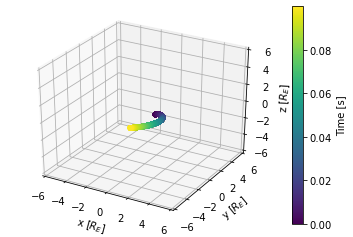

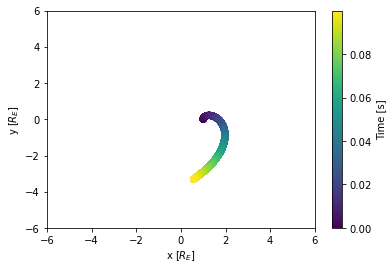

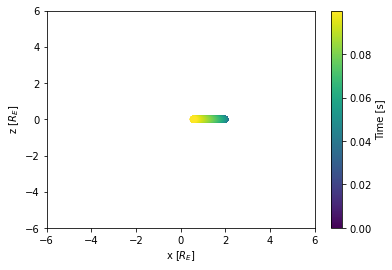

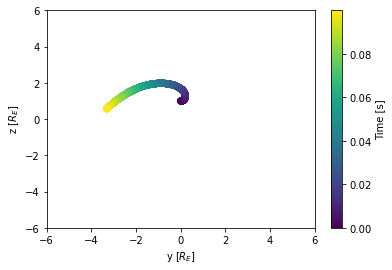

In [207]:
 # convert spherical coordinate trajectory arrays back to cartesian for plotting
(trajectory_t, trajectory_x, trajectory_y,
 trajectory_z) = get_trajectory_cartesian(trajectory_dict)

print(trajectory_x, trajectory_y, trajectory_z)

# plot the 3d plot and the projections onto each plane as well
plot_trajectories(trajectory_t, trajectory_x, trajectory_y, trajectory_z)

In [39]:
q = 1.602e-19
Bz = 2.91e-5

In [40]:
def dvxdt(vx, vy):
    return q*(vy*Bz)

def dvydt(vx, vy):
    return -q*(vx*Bz)


In [47]:
x = 3.
y = 3.
z = 3.
vx = 1.
vy = 1.
vz = 0.
dt = 0.0001

In [48]:
x_arr = []
y_arr = []
z_arr = []
vx_arr = []
vy_arr = []
vz_arr = []

In [49]:
for i in range(1000):
    x += dt * vx
    y += dt * vy
    vx += dt * dvxdt(vx, vy)
    vy += dt * dvydt(vx, vy)
    
#     print(np.sqrt(vx**2. + vy**2.))
    
    x_arr.append(x)
    y_arr.append(y)
    

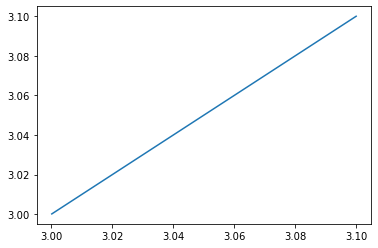

In [50]:
plt.plot(x_arr, y_arr)